In [23]:
import xarray as xr
import netCDF4 as NC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pylab
from matplotlib.colors import LogNorm
from cmocean import cm
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore")

from scipy.interpolate import griddata, interpn
import scipy.stats as stat

In [24]:
def calc_stats(x, y):
    stats = {}
    MSE = np.mean((y - x)**2)
    stats['RMSE'] = np.sqrt(MSE)
    stats['bias'] = np.mean(y) - np.mean(x)
    stats['WSS'] = 1 - MSE / np.mean((abs(y - np.mean(x)) + abs(x - np.mean(x)))**2)
    
    return stats


def plot_panel(ax, x, y, lims, units):
    stats = calc_stats(x, y)

    statstext = f"RMSE = {stats['RMSE']:.3f} {units}\nbias = {stats['bias']:.3f} {units}\nWSS = {stats['WSS']:.3f}"
    
    props = dict(boxstyle='round', facecolor='w', alpha=0.9)
    c = ax.text(0.01, 0.8, statstext, bbox=props, transform=ax.transAxes, fontsize=9)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    return c

In [25]:
ctd_202111 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202111/ObsModel_202111_ctd_from_dfo_20180101_20181231.csv')
ctd_2024XXa = pd.read_csv('/ocean/atall/MOAD/ObsModel/2024XXa/ObsModel_2024XXa_ctd_from_dfo_20190101_20191231.csv')
ctd_2024XXb = pd.read_csv('/ocean/atall/MOAD/ObsModel/2024XXb/ObsModel_2024XXb_ctd_from_dfo_20180101_20181220.csv')
ctd_2024XXa.head()

,Unnamed: 0,cid,Lon,Lat,dtUTC,Z,SA,CT,Oxygen_Dissolved,name,...,mod_ammonium,mod_diatoms,mod_flagellates,mod_vosaline,mod_votemper,mod_dissolved_oxygen,mod_vert_eddy_diff,mod_vert_eddy_visc,mod_dissipation,k
0,0,1383.0,-124.00852,49.346066,2019-01-09 16:44:59,0.7,28.264129,7.753743,NaN,NaN,...,1.933094,0.324228,0.217266,26.280537,6.824703,298.894623,0.000000,0.000000,0.000330,0
1,1,1383.0,-124.00852,49.346066,2019-01-09 16:44:59,1.1,28.257273,7.757942,NaN,NaN,...,1.933071,0.324273,0.217256,26.281094,6.825398,298.858246,0.035922,0.034103,0.000086,1
2,2,1383.0,-124.00852,49.346066,2019-01-09 16:44:59,2.6,28.256787,7.758623,NaN,NaN,...,1.933016,0.324295,0.217239,26.282112,6.826272,298.820343,0.036456,0.034789,0.000034,2
3,3,1383.0,-124.00852,49.346066,2019-01-09 16:44:59,3.9,28.257017,7.755378,NaN,NaN,...,1.932924,0.324304,0.217213,26.283714,6.827439,298.778809,0.036199,0.035046,0.000017,3
4,4,1383.0,-124.00852,49.346066,2019-01-09 16:44:59,5.2,28.257044,7.750723,NaN,NaN,...,1.932346,0.324321,0.217141,26.292261,6.832379,298.648621,0.030346,0.031128,0.000006,5


In [26]:
grid = xr.open_dataset('/ocean/atall/MOAD/grid/grid_from_lat_lon_mask999.nc')
with xr.open_dataset('/ocean/atall/MOAD/grid/mesh_mask_202310b.nc') as mesh:
    tmask = mesh.tmask
    mbathy = mesh.mbathy
    long = mesh.nav_lon
    latg = mesh.nav_lat
mesh

<xarray.Dataset>
Dimensions:       (y: 898, x: 398, z: 40, t: 1)
Dimensions without coordinates: y, x, z, t
Data variables: (12/44)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    time_counter  (t) float64 ...
    tmask         (t, z, y, x) int8 ...
    umask         (t, z, y, x) int8 ...
    ...            ...
    gdepv         (t, z, y, x) float32 ...
    gdepw_0       (t, z, y, x) float32 ...
    gdept_1d      (t, z) float64 ...
    gdepw_1d      (t, z) float64 ...
    e3t_1d        (t, z) float64 ...
    e3w_1d        (t, z) float64 ...
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  31/10/2023 18:41:52 -0400

In [27]:
t1 = '2019-01-01 00:00:00'
t2 = '2019-01-31 23:59:59'

lonSI1 = -123.58
lonSI2 = -123.44
latSI1 = 48.5
latSI2 = 48.695

lonSoG1 = -123.55
lonSoG2 = -123.1
latSoG1 = 48.95
latSoG2 = 49.25

print(lonSI1, lonSI2, latSI1, latSI2)
print(lonSoG1, lonSoG2, latSoG1, latSoG2)


-123.58 -123.44 48.5 48.695
-123.55 -123.1 48.95 49.25


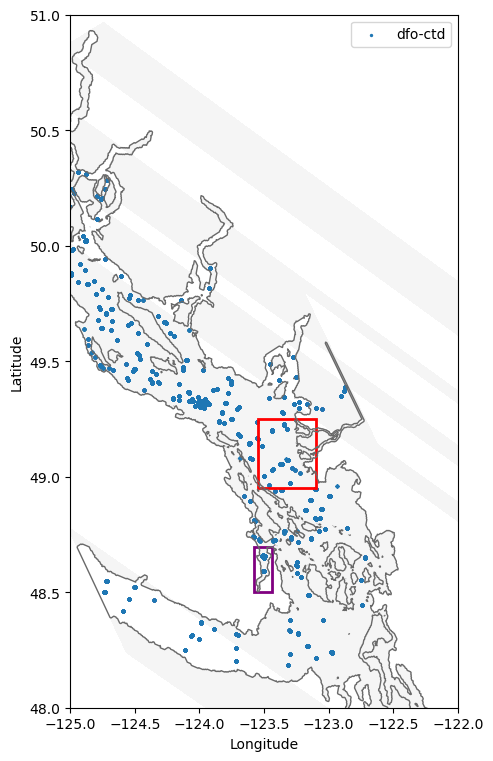

In [28]:
fig, ax = plt.subplots(1,1,figsize=(5, 9))

ax.contourf(long, latg, mbathy[0,:,:], linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
ax.contour(long, latg, mbathy[0,:,:], linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
#ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000, 2000], colors='dimgray', alpha=0.5)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
#ax.set_ylim([47,48.5])
#ax.set_xlim([-123.5,-122])
ax.set_ylim([48,51])
ax.set_xlim([-125,-122])

# plot the location of observations
ax.scatter(ctd_2024XXa.Lon[ctd_2024XXa.name != 'bottle'], ctd_2024XXa.Lat[ctd_2024XXa.name != 'bottle'], s=2, label="dfo-ctd")
#ax.scatter(ncei_bot.Lon[ncei_bot.name != 'ctd'], ncei_bot.Lat[ncei_bot.name != 'ctd'], s=2, label="ncei-bot")
#ax.scatter(bot.Lon, bot.Lat, s=2, label="bot")
ax.legend()
#ax.plot([lonSI1, lonSI2, lonSI2, lonSI1, lonSI1], [latSI1, latSI1, latSI2, latSI2, latSI1], '-','r')
leftSI, bottomSI, widthSI, heightSI = (lonSI1, latSI1, lonSI2-lonSI1, latSI2-latSI1)
leftSoG, bottomSoG, widthSoG, heightSoG = (lonSoG1, latSoG1, lonSoG2-lonSoG1, latSoG2-latSoG1)
rectSI=mpatches.Rectangle((leftSI,bottomSI),widthSI,heightSI, 
                        fill=False,
                        #alpha=0.1
                        color="purple",
                       linewidth=2,
                       label="Saanich Inlet")
rectSoG=mpatches.Rectangle((leftSoG,bottomSoG),widthSoG,heightSoG, 
                        fill=False,
                        #alpha=0.1
                        color="red",
                       linewidth=2,
                       label=" SI Sill")

plt.gca().add_patch(rectSI)
plt.gca().add_patch(rectSoG)


In [29]:
df_21_SI = ctd_202111[ ctd_202111['Lon'].between(lonSI1, lonSI2) & ctd_202111['Lat'].between(latSI1, latSI2) ]
df_XXa_SI = ctd_2024XXa[ ctd_2024XXa['Lon'].between(lonSI1, lonSI2) & ctd_2024XXa['Lat'].between(latSI1, latSI2) &
                         ctd_2024XXa['dtUTC'].between(t1, t2)]
df_XXb_SI = ctd_2024XXb[ ctd_2024XXb['Lon'].between(lonSI1, lonSI2) & ctd_2024XXb['Lat'].between(latSI1, latSI2) ]

df_21_SoG = ctd_202111[ ctd_202111['Lon'].between(lonSoG1, lonSoG2) & ctd_202111['Lat'].between(latSoG1, latSoG2) ]
df_XXa_SoG = ctd_2024XXa[ ctd_2024XXa['Lon'].between(lonSoG1, lonSoG2) & ctd_2024XXa['Lat'].between(latSoG1, latSoG2) &
                         ctd_2024XXa['dtUTC'].between(t1, t2)]
df_XXb_SoG = ctd_2024XXb[ ctd_2024XXb['Lon'].between(lonSoG1, lonSoG2) & ctd_2024XXb['Lat'].between(latSoG1, latSoG2) ]



In [30]:
def profilesSI(tracer,colour,ax):
    if tracer == 'Salinity':
        t_obs = 'SA'
        t_mod = 'mod_vosaline'
        unit = 'g/kg'
        unity ='meter'
    elif tracer == 'Temperature':
        t_obs = 'CT'
        t_mod = 'mod_votemper'
        unit = '$^{\circ} C$'
        unity ='meter'
    elif tracer == 'DO':
        t_obs = 'Oxygen_Dissolved'
        t_mod = 'mod_dissolved_oxygen'
        unit = 'uM'
        unity ='meter'
    elif tracer == 'NO3':
        t_obs = 'N'
        t_mod = 'mod_nitrate'
        unit = 'uM'
        unity ='meter'

    avg_obs_SI, bins_SIa, _ = stat.binned_statistic(-df_XXa_SI['Z'][(np.isfinite(df_XXa_SI[t_obs]))],df_XXa_SI[t_obs][(np.isfinite(df_XXa_SI[t_obs]))],statistic='mean',bins=50)
    avg_21_SI, bins_SI, _ = stat.binned_statistic(-df_21_SI['Z'][(np.isfinite(df_21_SI[t_mod]))],df_21_SI[t_mod][(np.isfinite(df_21_SI[t_mod]))],statistic='mean',bins=50)
    avg_XXa_SI, bins_SIa, _ = stat.binned_statistic(-df_XXa_SI['Z'][(np.isfinite(df_XXa_SI[t_mod]))],df_XXa_SI[t_mod][(np.isfinite(df_XXa_SI[t_mod]))],statistic='mean',bins=50)
    avg_XXb_SI, bins_SIb, _ = stat.binned_statistic(-df_XXb_SI['Z'][(np.isfinite(df_XXb_SI[t_mod]))],df_XXb_SI[t_mod][(np.isfinite(df_XXb_SI[t_mod]))],statistic='mean',bins=50)

    ax.plot(avg_obs_SI, bins_SIa[:-1], lw=2,label='obs')
    ax.plot(avg_21_SI, bins_SI[:-1], lw=2,label='202111')
    ax.plot(avg_XXa_SI, bins_SIa[:-1], lw=2,label='2024XXa')
    ax.plot(avg_XXb_SI, bins_SIb[:-1], lw=2,label='2024XXb')

    title = tracer
    #ax.set_title(title)
    ax.set_xlabel(unit)
    ax.set_ylabel(unity)

def profilesSoG(tracer,colour,ax):
    if tracer == 'Salinity':
        t_obs = 'SA'
        t_mod = 'mod_vosaline'
        unit = 'g/kg'
        unity ='meter'
    elif tracer == 'Temperature':
        t_obs = 'CT'
        t_mod = 'mod_votemper'
        unit = '$^{\circ} C$'
        unity ='meter'
    elif tracer == 'DO':
        t_obs = 'Oxygen_Dissolved'
        t_mod = 'mod_dissolved_oxygen'
        unit = 'uM'
        unity ='meter'
    elif tracer == 'NO3':
        t_obs = 'N'
        t_mod = 'mod_nitrate'
        unit = 'uM'
        unity ='meter'

    avg_obs_SoG, bins_SoGa, _ = stat.binned_statistic(-df_XXa_SoG['Z'][(np.isfinite(df_XXa_SoG[t_obs]))],df_XXa_SoG[t_obs][(np.isfinite(df_XXa_SoG[t_obs]))],statistic='mean',bins=50)
    avg_21_SoG, bins_SoG, _ = stat.binned_statistic(-df_21_SoG['Z'][(np.isfinite(df_21_SoG[t_mod]))],df_21_SoG[t_mod][(np.isfinite(df_21_SoG[t_mod]))],statistic='mean',bins=50)
    avg_XXa_SoG, bins_SoGa, _ = stat.binned_statistic(-df_XXa_SoG['Z'][(np.isfinite(df_XXa_SoG[t_mod]))],df_XXa_SoG[t_mod][(np.isfinite(df_XXa_SoG[t_mod]))],statistic='mean',bins=50)
    avg_XXb_SoG, bins_SoGb, _ = stat.binned_statistic(-df_XXb_SoG['Z'][(np.isfinite(df_XXb_SoG[t_mod]))],df_XXb_SoG[t_mod][(np.isfinite(df_XXb_SoG[t_mod]))],statistic='mean',bins=50)

    ax.plot(avg_obs_SoG, bins_SoGa[:-1], lw=2,label='obs')
    ax.plot(avg_21_SoG, bins_SoG[:-1], lw=2,label='202111')
    ax.plot(avg_XXa_SoG, bins_SoGa[:-1], lw=2,label='2024XXa')
    ax.plot(avg_XXb_SoG, bins_SoGb[:-1], lw=2,label='2024XXb')

    title = tracer
    #ax.set_title(title)
    ax.set_xlabel(unit)
    ax.set_ylabel(unity)

2018


ValueError: zero-size array to reduction operation minimum which has no identity

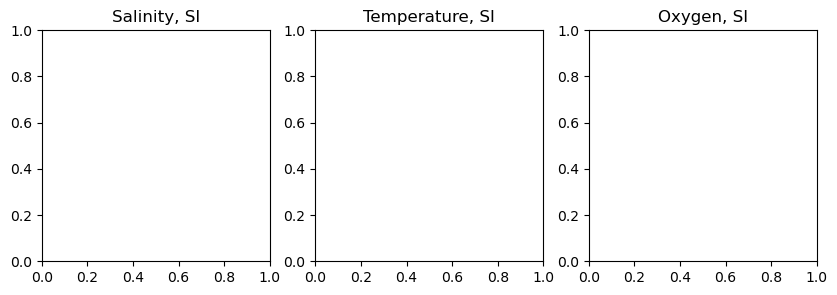

In [31]:
print('2018')
i, j, k = (0, 1, 2)
fig, ax = plt.subplots(1,3, figsize=(10,3))

title = 'Salinity, SI'
ax[i].set_title(title,fontsize=12)

title = 'Temperature, SI'
ax[j].set_title(title,fontsize=12)

title = 'Oxygen, SI'
ax[k].set_title(title,fontsize=12)

# plot profiles Saaanich Inlet

profilesSI('Salinity','k',ax[0])
profilesSI('Temperature','k',ax[1])
profilesSI('DO','k',ax[2])
ax[0].legend()
plt.tight_layout()
fig, ax = plt.subplots(1,3, figsize=(10,3))
title = 'Salinity, SoG'
ax[i].set_title(title,fontsize=12)
title = 'Temperature, SoG'
ax[j].set_title(title,fontsize=12)
title = 'Oxygen, SoG'
ax[k].set_title(title,fontsize=12)
profilesSoG('Salinity','k',ax[0])
profilesSoG('Temperature','k',ax[1])
profilesSoG('DO','k',ax[2])
ax[0].legend()
plt.tight_layout()

